In [1]:
import gpflow
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sys
sys.path.append('../')
from GPHetero import hetero_kernels, hetero_likelihoods, hetero_gpmc
from pyDOE import *
import os
from scipy.stats import norm

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

RuntimeError: module compiled against API version 0xb but this version of numpy is 0xa

In [2]:
class Ex5Func(object):

    def __init__(self, sigma=lambda x: 0.5):
        self.sigma = sigma

    def __call__(self, x):
        """
        Dette et. al. function.
        Dette, Holger, and Andrey Pepelyshev. "Generalized Latin hypercube design for computer experiments." Technometrics 52, no. 4 (2010): 421-429.

        """
        y = 4 * ((x[0] - 2 + 8 * x[1] - 8 * (x[1] ** 2)) ** 2) + (3 - 4 * x[1]) ** 2 + 16 * np.sqrt(x[2] + 1) * ((2 * x[2] - 1)**2)
        return (y - 50) / 50.

In [3]:
dim = 3
n = 50
noise=0
sigma = eval('lambda x: ' + str(noise))

objective = Ex5Func(sigma=sigma)
X = lhs(dim, n , criterion='center')
Xnorm = (X - 0.5) /0.5
Y = np.array([objective(x) for x in X])[:, None]

In [4]:
k = gpflow.kernels.RBF(3, ARD = True)
m = gpflow.gpr.GPR(Xnorm, Y, kern=k)
m.likelihood.variance = 1e-6

In [5]:
m.optimize(maxiter=5000)

      fun: -156.69080032545813
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -1.84319217e-07,   5.12247812e-05,  -8.93989124e-06,
        -2.96859071e-09,   2.02285787e-09])
  message: 'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 98
      nit: 49
   status: 2
  success: False
        x: array([   48.80749114,     2.84352496,     8.3487381 ,  1525.59027416,
         -36.04365563])

In [30]:
m

Name,values,prior,constraint
name.kern.lengthscales,[ 48.81450176 2.87963382 8.46690807],None,+ve
name.kern.variance,[ 1525.69651082],None,+ve
name.likelihood.variance,[ 1.00000000e-06],None,+ve


In [31]:
samples = m.sample(mcmc_samples, verbose=True, epsilon=0.0005, thin = 2, burn = 100, Lmax = 20)

burn-in sampling started
Iteration:  100 	 Acc Rate:  98.0 %
burn-in sampling ended
Iteration:  100 	 Acc Rate:  98.0 %
Iteration:  200 	 Acc Rate:  100.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  100.0 %


In [32]:
X_test = lhs(dim, n , criterion='center')
X_test_norm = (X_test - 0.5) /0.5
Y_test = np.array([objective(x) for x in X_test])[:, None]

In [33]:
sample_df = m.get_samples_df(samples)
mean_f_mat = np.zeros(shape=(sample_df.shape[0], X_test_norm.shape[0]))
var_f_mat = np.zeros(shape=(sample_df.shape[0], X_test_norm.shape[0]))

In [34]:
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    mean_f, var_f = m.predict_f(X_test_norm)
    mean_f_mat[i, :] = mean_f[:,0]
    var_f_mat[i, :] = np.diag(var_f)

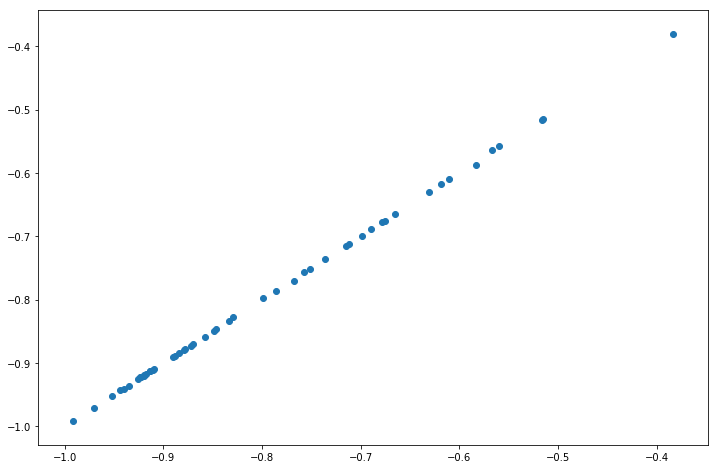

In [47]:
plt.figure(figsize=(12,8))
plt.scatter(mean_f_mat[0,:], Y_test)